In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-cases/S1. Curated Input.csv
/kaggle/input/test-cases/S2. Example Input.csv
/kaggle/input/xai-dataset-2/clinical_mastitis_cows.csv


In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import shap

2024-06-25 17:16:57.258070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 17:16:57.258205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 17:16:57.405865: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Processing

In [3]:
# Load the dataset
file_path = "/kaggle/input/xai-dataset-2/clinical_mastitis_cows.csv"  # Update with the correct path
df = pd.read_csv(file_path)

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Load dataset 

df = df.drop(columns=[ 'Day','Cow_ID','Hardness','Pain','Milk_visibility','Previous_Mastits_status','Breed'])
df = pd.get_dummies(df)

df

Months after giving birth  IUFL  EUFL  IUFR  EUFR  IURL  EURL  IURR  \
0                             1   150   180   150   180   150   181   150   
1                             1   152   180   152   185   151   180   152   
2                             1   152   182   153   186   151   186   153   
3                             1   155   183   155   189   155   182   155   
4                             1   150   186   150   181   150   185   150   
...                         ...   ...   ...   ...   ...   ...   ...   ...   
6595                          5   243   285   310   361   241   285   246   
6596                          5   240   276   315   358   242   285   247   
6597                          5   242   286   315   365   237   279   248   
6598                          5   245   285   314   361   239   280   241   
6599                          5   247   278   316   364   242   278   238   

      EURR  Temperature  class1  
0      181           43       0  
1      181           42       0  
2      183           41       0  
3      186           40       0  
4      188           41       0  
...    ...          ...     ...  
6595   281           43       1  
6596   284           43       1  
6597   288           43       1  
6598   288           43       1  
6599   285           43       1  

[6600 rows x 11 columns]

In [5]:
#df['Breed_Jersey'] = df['Breed_Jersey'].apply(lambda x: 1 if x else 0)
#df['Breed_hostlene'] = df['Breed_hostlene'].apply(lambda x: 1 if x else 0)


y = df['class1'].values


x = df.drop('class1', axis=1)
x.info()
x

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6600 entries, 0 to 6599
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Months after giving birth  6600 non-null   int64
 1   IUFL                       6600 non-null   int64
 2   EUFL                       6600 non-null   int64
 3   IUFR                       6600 non-null   int64
 4   EUFR                       6600 non-null   int64
 5   IURL                       6600 non-null   int64
 6   EURL                       6600 non-null   int64
 7   IURR                       6600 non-null   int64
 8   EURR                       6600 non-null   int64
 9   Temperature                6600 non-null   int64
dtypes: int64(10)
memory usage: 515.8 KB


Months after giving birth  IUFL  EUFL  IUFR  EUFR  IURL  EURL  IURR  \
0                             1   150   180   150   180   150   181   150   
1                             1   152   180   152   185   151   180   152   
2                             1   152   182   153   186   151   186   153   
3                             1   155   183   155   189   155   182   155   
4                             1   150   186   150   181   150   185   150   
...                         ...   ...   ...   ...   ...   ...   ...   ...   
6595                          5   243   285   310   361   241   285   246   
6596                          5   240   276   315   358   242   285   247   
6597                          5   242   286   315   365   237   279   248   
6598                          5   245   285   314   361   239   280   241   
6599                          5   247   278   316   364   242   278   238   

      EURR  Temperature  
0      181           43  
1      181           42  
2      183           41  
3      186           40  
4      188           41  
...    ...          ...  
6595   281           43  
6596   284           43  
6597   288           43  
6598   288           43  
6599   285           43  

[6600 rows x 10 columns]

col:  Months after giving birth


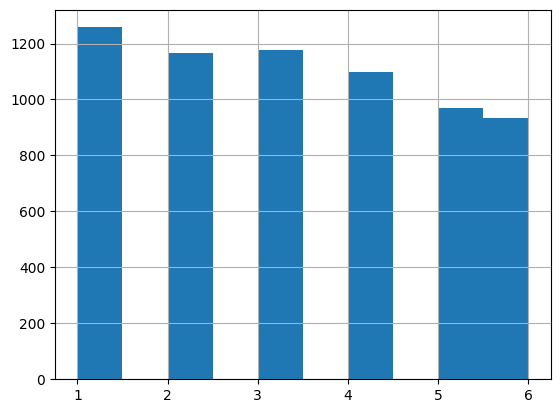

col:  IUFL


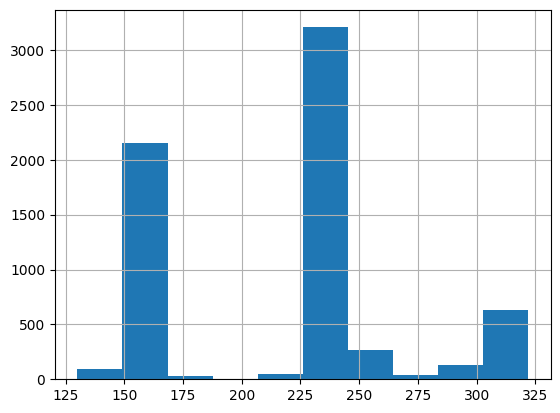

col:  EUFL


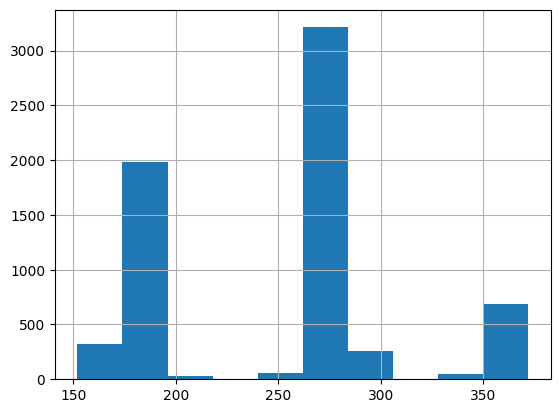

col:  IUFR


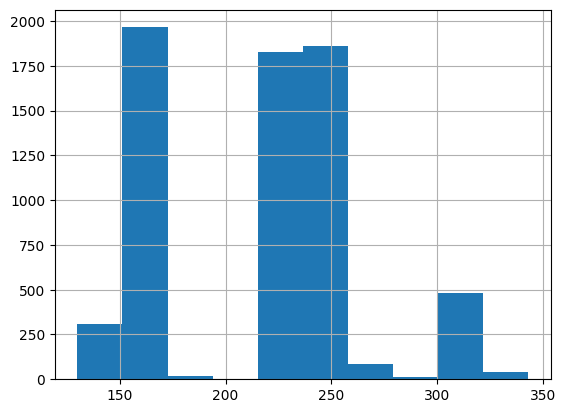

col:  EUFR


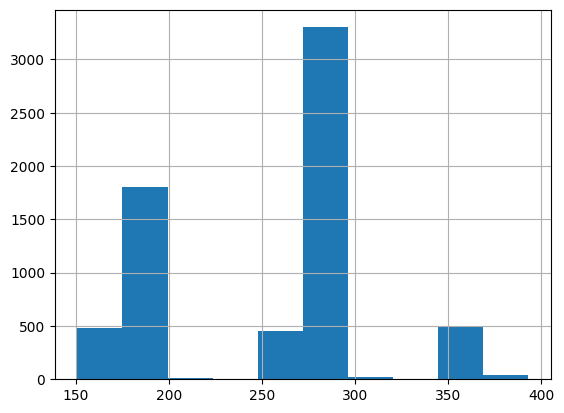

col:  IURL


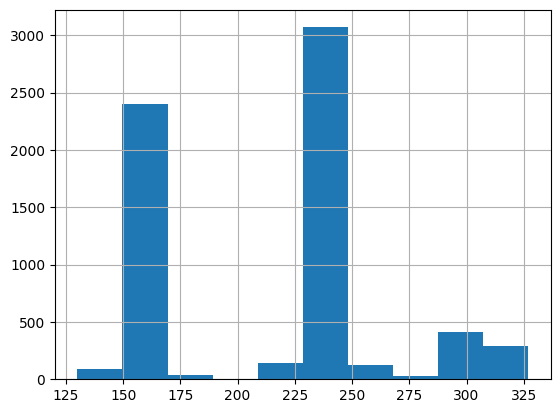

col:  EURL


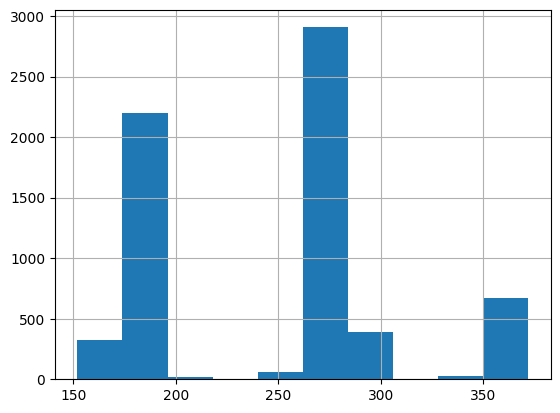

col:  IURR


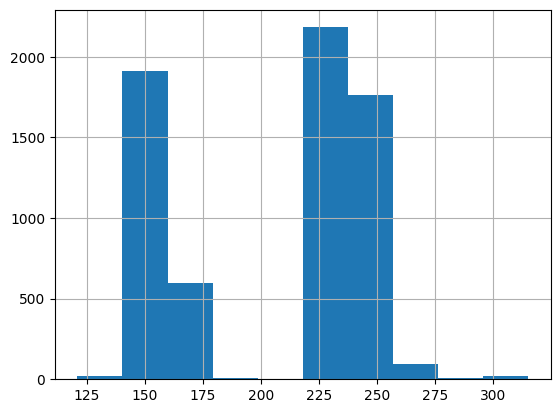

col:  EURR


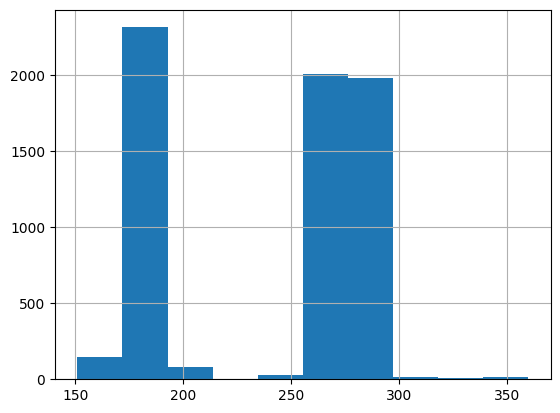

col:  Temperature


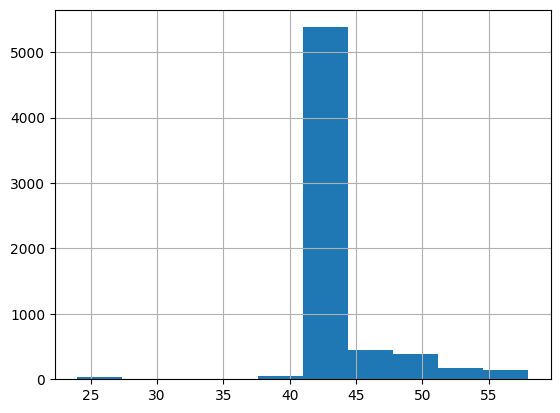

col:  class1


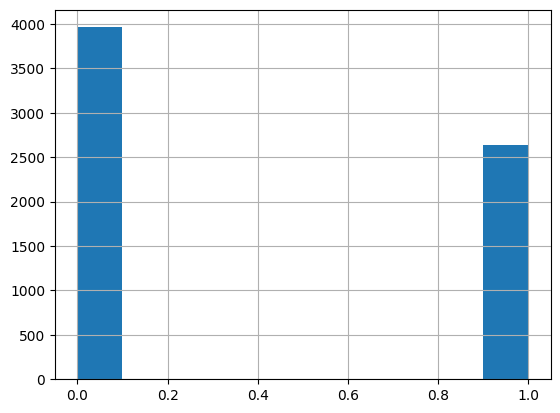

In [6]:
import matplotlib.pyplot as plt

columns = df.columns
for col in columns:
    print("col: ", col)
    df[col].hist()
    plt.show()

In [7]:
# Split data into training, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

print("Training set size:", X_train.shape[0], "or", round(X_train.shape[0]/x.shape[0]*100, 1), "%")
print("Test set size:", X_test.shape[0], "or", round(X_test.shape[0]/x.shape[0]*100, 1), "%")
print("Validation set size:", X_val.shape[0], "or", round(X_val.shape[0]/x.shape[0]*100, 1), "%")

Training set size: 4620 or 70.0 %
Test set size: 1326 or 20.1 %
Validation set size: 654 or 9.9 %


In [8]:
# Reshape the input data for LSTM (samples, time steps, features)
n_features = X_train.shape[1]
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, n_features))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, n_features))
X_val_reshaped = X_val.values.reshape((X_val.shape[0], 1, n_features))

X_val_reshaped

array([[[  5, 160, 181, ..., 155, 184,  43]],

       [[  1, 243, 279, ..., 243, 281,  43]],

       [[  3, 160, 192, ..., 164, 192,  43]],

       ...,

       [[  3, 164, 192, ..., 171, 191,  43]],

       [[  3, 232, 282, ..., 239, 281,  43]],

       [[  4, 231, 272, ..., 237, 270,  43]]])

# LSTM Model

In [9]:
# Define and compile the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, n_features)),
    LSTM(50),
    Dense(1, activation='sigmoid')
])


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=50, validation_data=(X_val_reshaped, y_val))

Epoch 1/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7367 - loss: 0.5491 - val_accuracy: 0.8976 - val_loss: 0.3152
Epoch 2/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8948 - loss: 0.3145 - val_accuracy: 0.8930 - val_loss: 0.3130
Epoch 3/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8930 - loss: 0.3120 - val_accuracy: 0.8930 - val_loss: 0.3216
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8934 - loss: 0.3176 - val_accuracy: 0.8991 - val_loss: 0.4004
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8893 - loss: 0.3337 - val_accuracy: 0.8899 - val_loss: 0.3120
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8982 - loss: 0.2994 - val_accuracy: 0.8914 - val_loss: 0.3116
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8919 - loss: 0.3162 - val_accuracy: 0.8991 - val_loss: 0.2923
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8954 - loss: 0.2972 - val_accuracy: 0.

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 50)          │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,355 (380.30 KB)

 Trainable params: 32,451 (126.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 64,904 (253.54 KB)

In [13]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print("Test Accuracy:", test_acc)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8808 - loss: 0.3220
Test Accuracy: 0.8944193124771118


In [14]:
# Making predictions
predictions = model.predict(X_test_reshaped)
binary_predictions = (predictions > 0.5).astype(int)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [15]:
import pandas as pd

# Assuming 'predictions' are in the format returned by model.predict() and are probabilities
# Flatten the predictions array and round them off for better readability
predicted_probs = predictions.flatten().round(2)

# Create a DataFrame from the test set features
test_features = pd.DataFrame(X_test_reshaped.reshape(X_test_reshaped.shape[0], n_features), columns=X_test.columns)

# Add the predictions and the actual labels to the DataFrame
test_features['Predicted Probability'] = predicted_probs
test_features['Actual Label'] = y_test  

# Sort the DataFrame by 'Predicted Probability' to get the top predictions
test_features_sorted = test_features.sort_values(by='Predicted Probability', ascending=False)

In [16]:
# Display the top 5 predictions
top_5_predictions = test_features_sorted.head(5)
print(top_5_predictions)

      Months after giving birth  IUFL  EUFL  IUFR  EUFR  IURL  EURL  IURR  \
1051                          6   231   280   240   281   303   358   233   
1024                          1   313   357   248   288   245   281   248   
449                           1   303   352   237   279   233   275   241   
444                           3   306   356   239   280   235   274   238   
443                           1   232   281   241   282   304   359   234   

      EURR  Temperature  Predicted Probability  Actual Label  
1051   275           43                    1.0             1  
1024   285           43                    1.0             1  
449    275           46                    1.0             1  
444    274           56                    1.0             1  
443    276           43                    1.0             1  


In [17]:
 top_5_predictions.to_csv("top_5_predictions_v1.0.csv", index=False)
top_5_predictions.info

<bound method DataFrame.info of       Months after giving birth  IUFL  EUFL  IUFR  EUFR  IURL  EURL  IURR  \
1051                          6   231   280   240   281   303   358   233   
1024                          1   313   357   248   288   245   281   248   
449                           1   303   352   237   279   233   275   241   
444                           3   306   356   239   280   235   274   238   
443                           1   232   281   241   282   304   359   234   

      EURR  Temperature  Predicted Probability  Actual Label  
1051   275           43                    1.0             1  
1024   285           43                    1.0             1  
449    275           46                    1.0             1  
444    274           56                    1.0             1  
443    276           43                    1.0             1  >

In [18]:
# Convert probabilities to binary predictions
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

In [19]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Model Evaluation

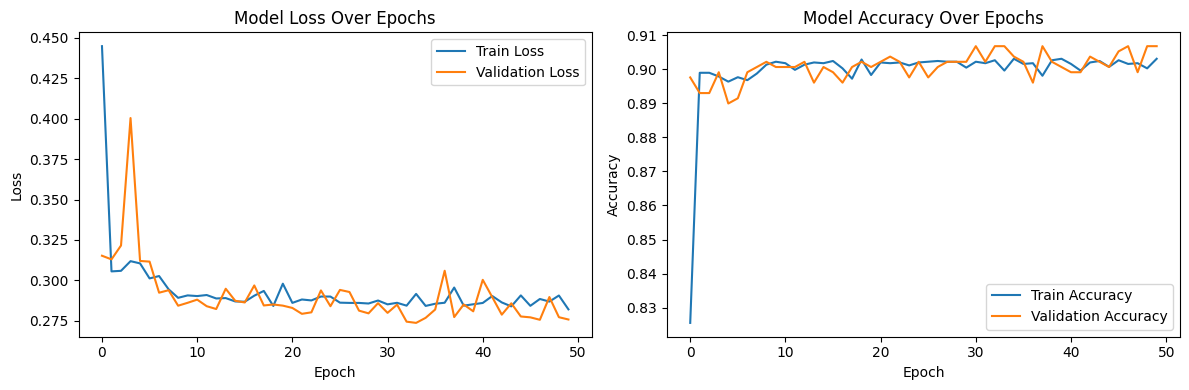

In [20]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

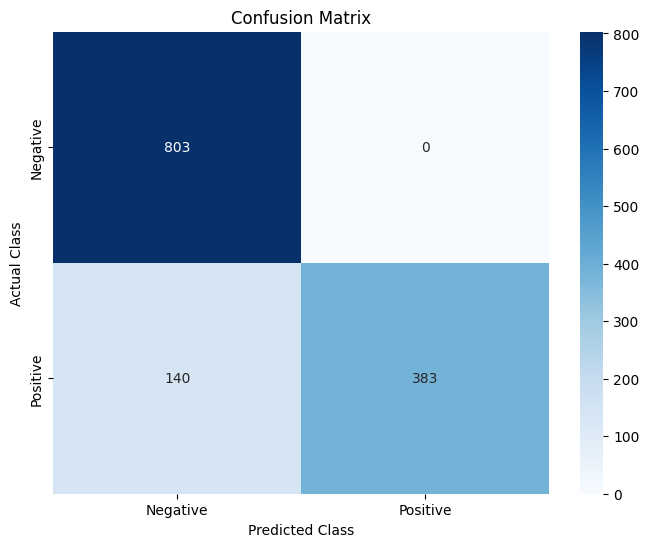

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the labels for the confusion matrix (adjust labels for your specific case)
labels = ['Negative', 'Positive']

# Create a heatmap from the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8944193061840121
Precision: 1.0
Recall: 0.7323135755258127
F1 Score: 0.8454746136865342


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


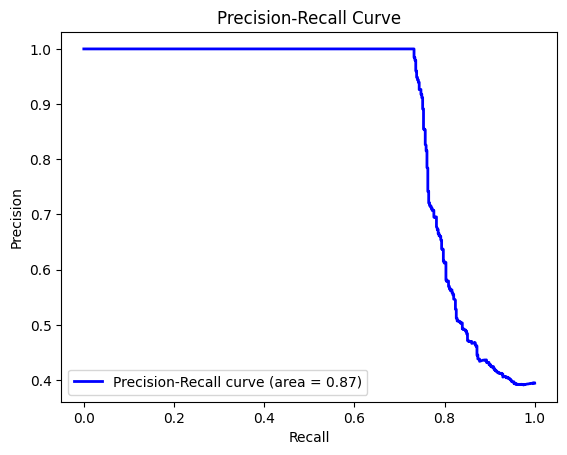

In [23]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Predict probabilities
y_pred_prob = model.predict(X_test_reshaped).ravel()
# Compute precision-recall pairs for different probability thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Compute average precision score
average_precision = average_precision_score(y_test, y_pred_prob)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall curve (area = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

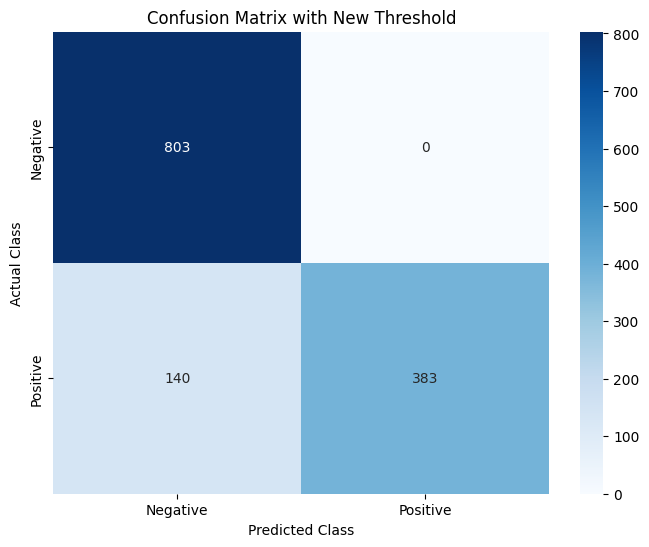

In [24]:
# Adjusting threshold to prioritize recall
new_threshold = 0.4
new_binary_predictions = (predictions > new_threshold).astype(int)
new_conf_matrix = confusion_matrix(y_test, new_binary_predictions)

# Redisplay new confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(new_conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix with New Threshold')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

True Negatives (TN): 803
False Positives (FP): 0
False Negatives (FN): 140
True Positives (TP): 383


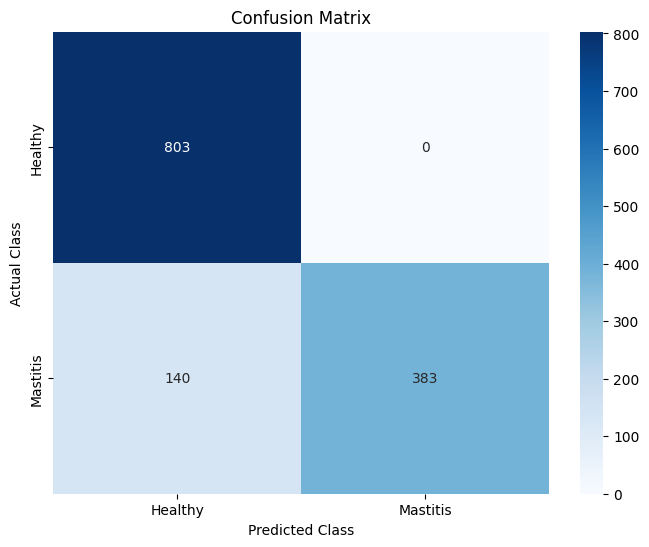

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming binary_predictions and y_test are already defined

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Extract TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix.ravel()

# Print TN, FP, FN, TP
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")

# Optional: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Healthy', 'Mastitis'], yticklabels=['Healthy', 'Mastitis'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


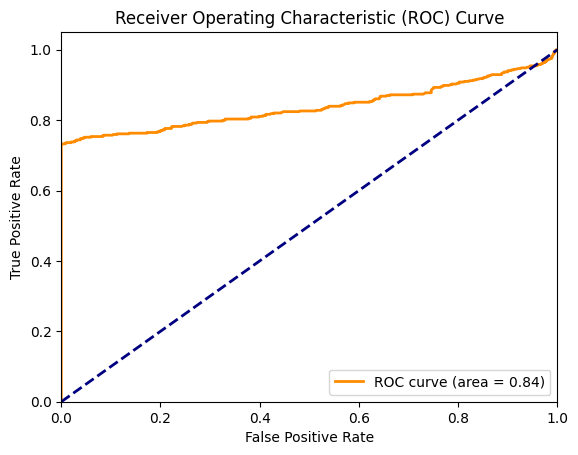

In [26]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_pred_prob = model.predict(X_test_reshaped).ravel()

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [27]:
print(model.output_shape)

(None, 1)


In [28]:
# Making predictions
predictions = model.predict(X_test_reshaped)
binary_predictions = (predictions > 0.5).astype(int)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


# SHAP Value Calculation and Visualization

In [29]:
X_train_flat = X_train.values
X_test_flat = X_test.values

In [30]:
def model_predict(data):
    reshaped_data = data.reshape(data.shape[0], 1, data.shape[1])
    return model.predict(reshaped_data)

In [31]:
# Initialize KernelExplainer with a sample of the training data
explainer = shap.KernelExplainer(model_predict, shap.sample(X_train_flat, 100))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [32]:
shap_values = explainer.shap_values(X_test_flat[:50], nsamples=100)

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━

In [33]:
# Ensure that single_record_features is correctly shaped
single_record_features = X_test_flat[0]  # This assumes X_test_flat is (samples, features) and already 2D

# Check the shape or length
print("Features length:", len(single_record_features))

# Select SHAP values for a single record, assuming shap_values is a 2D array
single_record_shap_values = shap_values[0]
print("Correctly selected SHAP values length:", len(single_record_shap_values))

Features length: 10
Correctly selected SHAP values length: 50


In [34]:
explainer.expected_value

array([0.42530222])

In [35]:
single_record_features = X_test_flat[0] 
print("Features shape:", single_record_features.shape)

print("SHAP values:", single_record_shap_values)
print("Feature values:", single_record_features)


Features shape: (10,)
SHAP values: [[ 0.         -0.05752975 -0.07373293  0.          0.04716324  0.
   0.         -0.0293993  -0.12024119 -0.01170156]
 [ 0.          0.04100423  0.05570226  0.03076837  0.45472928 -0.04043057
   0.08340012 -0.02545371 -0.02754866  0.        ]
 [ 0.          0.         -0.22637457 -0.09318642 -0.0866154   0.10533781
  -0.16107362  0.06351121  0.16437606 -0.01128525]
 [ 0.          0.04798912  0.05142449  0.          0.05010592 -0.05953775
   0.52186933  0.         -0.03967978  0.        ]
 [ 0.          0.         -0.27934674 -0.02573375 -0.05593035  0.09633885
  -0.11841355  0.07640915  0.06123933  0.        ]
 [ 0.         -0.07188873  0.03597599  0.01224002 -0.06265441 -0.05486606
  -0.01489377 -0.01360126 -0.07576091  0.        ]
 [ 0.          0.02350106 -0.23846155 -0.04467922 -0.08900944  0.101405
  -0.13586494  0.03365747  0.10401404  0.        ]
 [ 0.          0.         -0.21643499 -0.0861495  -0.08489798  0.0789946
  -0.18557765  0.09909481  

In [36]:
shap.initjs()

# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value[0], shap_values[0][0],        # Use the flattened SHAP values
    X_test_flat[0],       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

In [37]:
shap_html = shap.force_plot(
    explainer.expected_value[0], shap_values[0][0],        # Use the flattened SHAP values
    X_test_flat[0],       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

shap.save_html('/kaggle/working/force_plot_1.html', shap_html)

In [38]:
shap.initjs()

# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value[0], shap_values[0][1],        # Use the flattened SHAP values
    X_test_flat[1],       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

In [39]:
shap_html = shap.force_plot(
    explainer.expected_value[0], shap_values[0][1],        # Use the flattened SHAP values
    X_test_flat[1],       # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

shap.save_html('/kaggle/working/force_plot_2.html', shap_html)

In [40]:
shap_values

[array([[ 0.        , -0.05752975, -0.07373293,  0.        ,  0.04716324,
          0.        ,  0.        , -0.0293993 , -0.12024119, -0.01170156],
        [ 0.        ,  0.04100423,  0.05570226,  0.03076837,  0.45472928,
         -0.04043057,  0.08340012, -0.02545371, -0.02754866,  0.        ],
        [ 0.        ,  0.        , -0.22637457, -0.09318642, -0.0866154 ,
          0.10533781, -0.16107362,  0.06351121,  0.16437606, -0.01128525],
        [ 0.        ,  0.04798912,  0.05142449,  0.        ,  0.05010592,
         -0.05953775,  0.52186933,  0.        , -0.03967978,  0.        ],
        [ 0.        ,  0.        , -0.27934674, -0.02573375, -0.05593035,
          0.09633885, -0.11841355,  0.07640915,  0.06123933,  0.        ],
        [ 0.        , -0.07188873,  0.03597599,  0.01224002, -0.06265441,
         -0.05486606, -0.01489377, -0.01360126, -0.07576091,  0.        ],
        [ 0.        ,  0.02350106, -0.23846155, -0.04467922, -0.08900944,
          0.101405  , -0.1358649

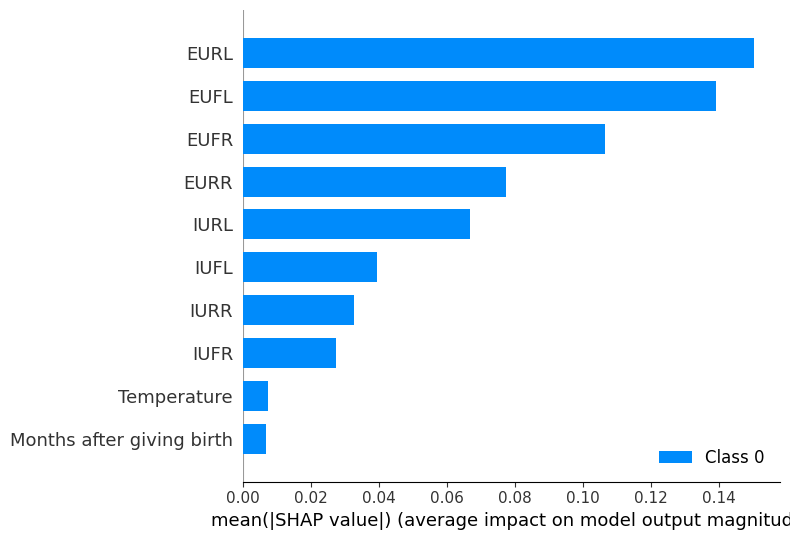

In [41]:
shap.summary_plot(
    shap_values,
    X_test_flat[:50],  # Use the features corresponding to the SHAP values
    feature_names=X_test.columns.tolist()[:15]  # Ensure the feature names list is correctly aligned
)

In [42]:
shap.plots.force(explainer.expected_value,shap_values[0],feature_names=X_test.columns.tolist())

In [43]:
shap_html = shap.plots.force(explainer.expected_value,shap_values[0],feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/General_force_plot.html', shap_html)

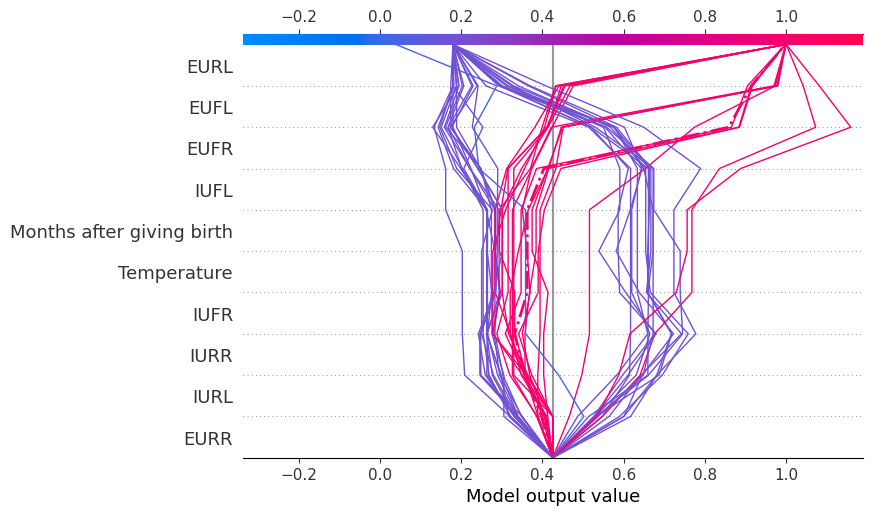

In [44]:
shap.decision_plot(explainer.expected_value, shap_values[0], feature_names=X_test.columns.tolist(),link="identity", highlight=1,legend_location="best",
                  feature_order="hclust")

In [45]:
# Flatten the SHAP values to match the expected shape (samples, features)
shap_values_flat_1 = np.array(shap_values).reshape((50, 10))
shap_values_flat_1
shap_values_expl_1 = shap.Explanation(values=shap_values_flat_1, base_values=explainer.expected_value, data=X_test_flat[:50], feature_names=X_test.columns.tolist())

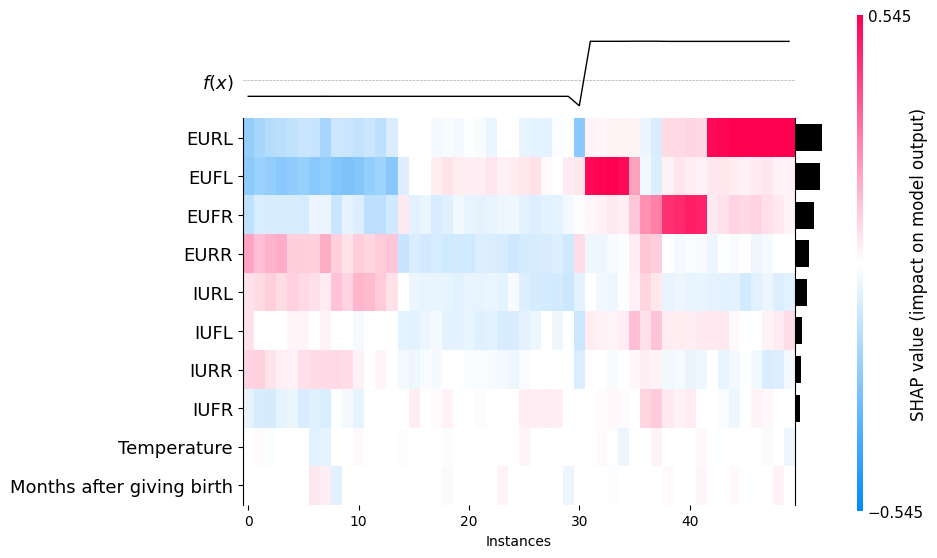

In [46]:
shap.plots.heatmap(shap_values_expl_1, max_display=15)

In [47]:
top_5_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 1051 to 443
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Months after giving birth  5 non-null      int64  
 1   IUFL                       5 non-null      int64  
 2   EUFL                       5 non-null      int64  
 3   IUFR                       5 non-null      int64  
 4   EUFR                       5 non-null      int64  
 5   IURL                       5 non-null      int64  
 6   EURL                       5 non-null      int64  
 7   IURR                       5 non-null      int64  
 8   EURR                       5 non-null      int64  
 9   Temperature                5 non-null      int64  
 10  Predicted Probability      5 non-null      float32
 11  Actual Label               5 non-null      int64  
dtypes: float32(1), int64(11)
memory usage: 500.0 bytes


In [48]:
X_sample_test = top_5_predictions.drop(columns=[ 'Predicted Probability','Actual Label'])
X_sample_test

Months after giving birth  IUFL  EUFL  IUFR  EUFR  IURL  EURL  IURR  \
1051                          6   231   280   240   281   303   358   233   
1024                          1   313   357   248   288   245   281   248   
449                           1   303   352   237   279   233   275   241   
444                           3   306   356   239   280   235   274   238   
443                           1   232   281   241   282   304   359   234   

      EURR  Temperature  
1051   275           43  
1024   285           43  
449    275           46  
444    274           56  
443    276           43

In [49]:
Y_sample_test = top_5_predictions['Actual Label'].values
Y_sample_test

array([1, 1, 1, 1, 1])

In [50]:
X_test_flat[:20]
shap_values

[array([[ 0.        , -0.05752975, -0.07373293,  0.        ,  0.04716324,
          0.        ,  0.        , -0.0293993 , -0.12024119, -0.01170156],
        [ 0.        ,  0.04100423,  0.05570226,  0.03076837,  0.45472928,
         -0.04043057,  0.08340012, -0.02545371, -0.02754866,  0.        ],
        [ 0.        ,  0.        , -0.22637457, -0.09318642, -0.0866154 ,
          0.10533781, -0.16107362,  0.06351121,  0.16437606, -0.01128525],
        [ 0.        ,  0.04798912,  0.05142449,  0.        ,  0.05010592,
         -0.05953775,  0.52186933,  0.        , -0.03967978,  0.        ],
        [ 0.        ,  0.        , -0.27934674, -0.02573375, -0.05593035,
          0.09633885, -0.11841355,  0.07640915,  0.06123933,  0.        ],
        [ 0.        , -0.07188873,  0.03597599,  0.01224002, -0.06265441,
         -0.05486606, -0.01489377, -0.01360126, -0.07576091,  0.        ],
        [ 0.        ,  0.02350106, -0.23846155, -0.04467922, -0.08900944,
          0.101405  , -0.1358649

In [51]:
X_sample_test_flat = X_sample_test.values
X_sample_test_flat

array([[  6, 231, 280, 240, 281, 303, 358, 233, 275,  43],
       [  1, 313, 357, 248, 288, 245, 281, 248, 285,  43],
       [  1, 303, 352, 237, 279, 233, 275, 241, 275,  46],
       [  3, 306, 356, 239, 280, 235, 274, 238, 274,  56],
       [  1, 232, 281, 241, 282, 304, 359, 234, 276,  43]])

In [52]:
# Initialize KernelExplainer with a sample of the training data
explainer = shap.KernelExplainer(model_predict, shap.sample(X_sample_test_flat))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [53]:
shap_values_v1 = explainer.shap_values(X_sample_test_flat, nsamples=100)

  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [54]:
shap_values_v1

[array([[ 0.        ,  0.19409402, -0.26397597, -0.00621944,  0.        ,
         -0.06893672,  0.15505652, -0.01077807,  0.        ,  0.        ],
        [ 0.        , -0.08585897,  0.12072916,  0.        ,  0.        ,
          0.09015683, -0.11069172,  0.        ,  0.        , -0.01382885],
        [ 0.        , -0.10568185,  0.12590272,  0.        ,  0.        ,
          0.08311016, -0.1353721 ,  0.        ,  0.03254753,  0.        ],
        [ 0.        , -0.09820776,  0.1591554 ,  0.        ,  0.        ,
          0.06916643, -0.11191885,  0.        ,  0.        , -0.01768877],
        [-0.04485433,  0.15056975, -0.19835861,  0.02236705, -0.03303841,
         -0.08086697,  0.1370154 ,  0.        ,  0.        ,  0.04640644]])]

In [55]:
shap.initjs()
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][0],X_sample_test_flat[0],       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [56]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][0],single_record_features,       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_0.html', shap_html)

In [57]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][1],X_sample_test_flat[1],       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [58]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][1],X_sample_test_flat[1],       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_1.html', shap_html)

In [59]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][2],X_sample_test_flat[2],       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [60]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][2],X_sample_test_flat[2],       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_2.html', shap_html)

In [61]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][3],X_sample_test_flat[3],       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [62]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][3],X_sample_test_flat[3],       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_3.html', shap_html)

In [63]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values_v1[0][4],X_sample_test_flat[4],       # Feature values for the single record
    feature_names=X_test.columns.tolist())

In [64]:
shap_html = shap.force_plot(explainer.expected_value,shap_values_v1[0][4],X_sample_test_flat[4],       # Feature values for the single record
    feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/prediction_force_plot_4.html', shap_html)

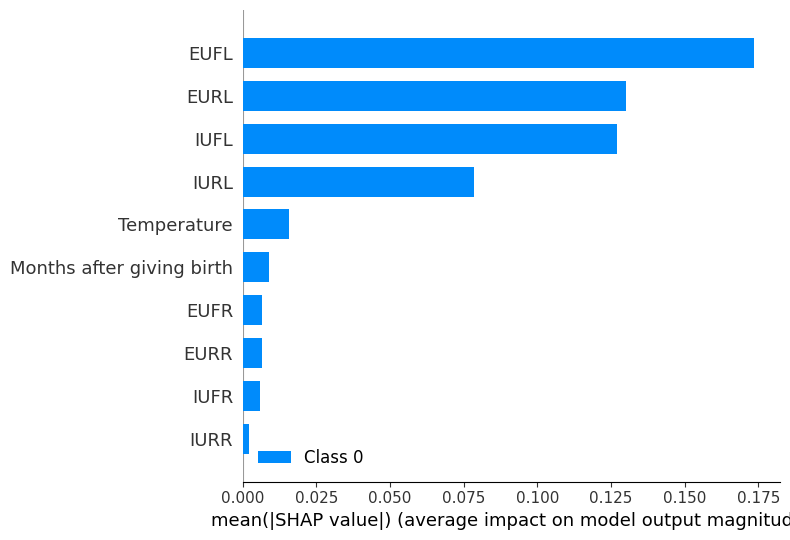

In [65]:
shap.summary_plot(
    shap_values_v1,
    X_sample_test_flat,
    feature_names=X_test.columns.tolist()[:15], 
)

In [66]:
shap.plots.force(explainer.expected_value,shap_values_v1[0],feature_names=X_test.columns.tolist())

In [67]:
  shap_html = shap.force_plot(
    explainer.expected_value,shap_values_v1[0],feature_names=X_test.columns.tolist())

shap.save_html('/kaggle/working/top_5_predictions_force_plot_1.html', shap_html)

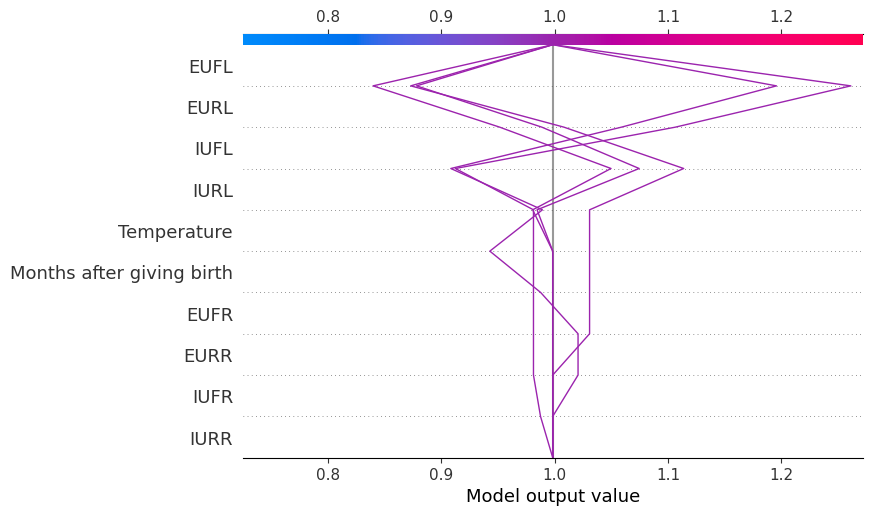

In [68]:
shap.decision_plot(explainer.expected_value, shap_values_v1[0], feature_names=X_test.columns.tolist(),)

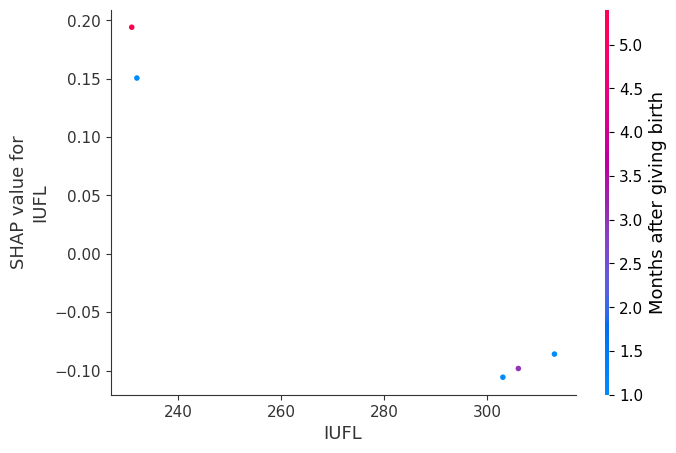

In [69]:
shap.dependence_plot(1, shap_values_v1[0], X_sample_test_flat,feature_names=X_test.columns.tolist())

In [70]:
# Flatten the SHAP values to match the expected shape (samples, features)
shap_values_flat = np.array(shap_values_v1).reshape((5, 10))
shap_values_flat


array([[ 0.        ,  0.19409402, -0.26397597, -0.00621944,  0.        ,
        -0.06893672,  0.15505652, -0.01077807,  0.        ,  0.        ],
       [ 0.        , -0.08585897,  0.12072916,  0.        ,  0.        ,
         0.09015683, -0.11069172,  0.        ,  0.        , -0.01382885],
       [ 0.        , -0.10568185,  0.12590272,  0.        ,  0.        ,
         0.08311016, -0.1353721 ,  0.        ,  0.03254753,  0.        ],
       [ 0.        , -0.09820776,  0.1591554 ,  0.        ,  0.        ,
         0.06916643, -0.11191885,  0.        ,  0.        , -0.01768877],
       [-0.04485433,  0.15056975, -0.19835861,  0.02236705, -0.03303841,
        -0.08086697,  0.1370154 ,  0.        ,  0.        ,  0.04640644]])

In [71]:
import shap
shap_values_expl = shap.Explanation(values=shap_values_flat, base_values=explainer.expected_value, data=X_test_flat, feature_names=X_test.columns.tolist())


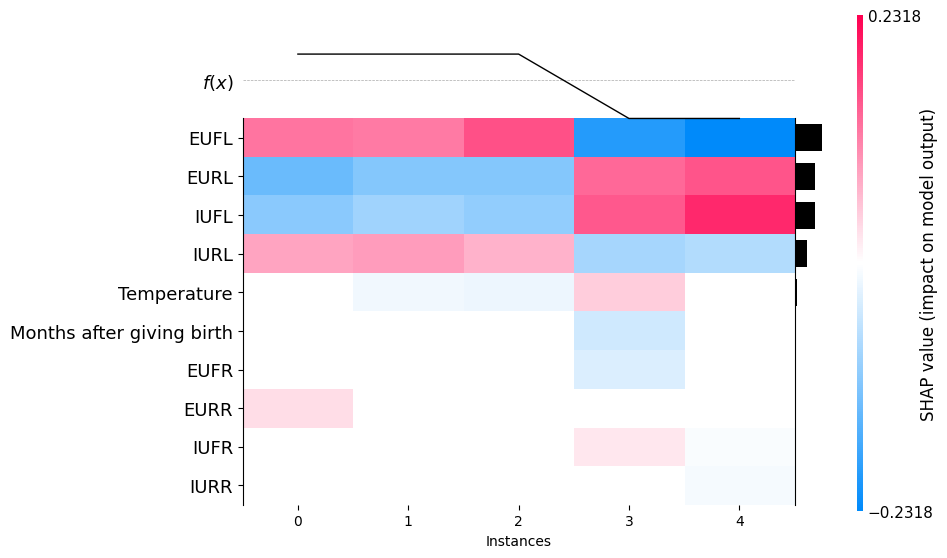

In [72]:
# Visualize SHAP values using heatmap
shap.plots.heatmap(shap_values_expl, max_display=15)

# Smooth Curve Model

Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8893 - loss: 0.3068 - val_accuracy: 0.9134 - val_loss: 0.2578
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8945 - loss: 0.3012 - val_accuracy: 0.9134 - val_loss: 0.2620
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9015 - loss: 0.2879 - val_accuracy: 0.9113 - val_loss: 0.2672
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9002 - loss: 0.2906 - val_accuracy: 0.9134 - val_loss: 0.2616
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9065 - loss: 0.2774 - val_accuracy: 0.9156 - val_loss: 0.2580
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8906 - loss: 0.3043 - val_accuracy: 0.9156 - val_loss: 0.2573
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8977 - loss: 0.2967 - val_accuracy: 0.9145 - val_loss: 0.2588
Epoch 8/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9009 - loss: 0.2881 - val_accuracy: 0.

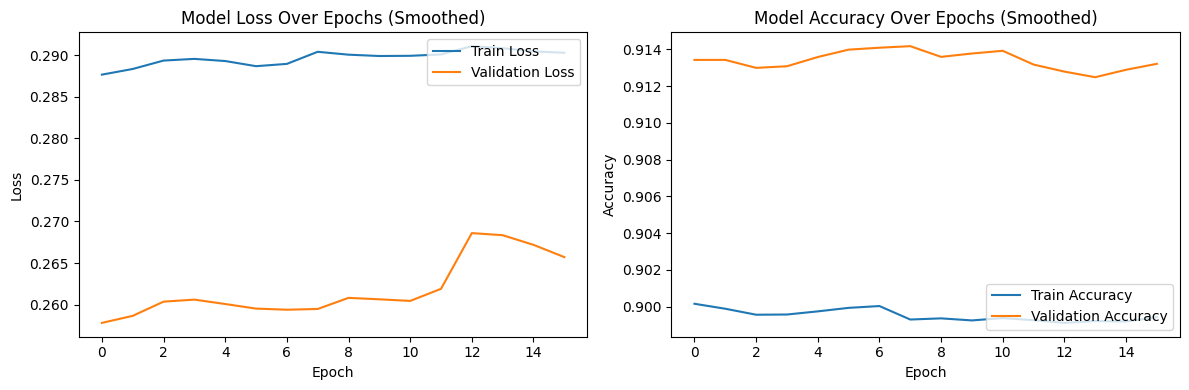

In [73]:
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

# Smoothing function
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Smooth the curves
smooth_train_loss = smooth_curve(history.history['loss'])
smooth_val_loss = smooth_curve(history.history['val_loss'])
smooth_train_acc = smooth_curve(history.history['accuracy'])
smooth_val_acc = smooth_curve(history.history['val_accuracy'])

# Plot smoothed training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(smooth_train_loss, label='Train Loss')
plt.plot(smooth_val_loss, label='Validation Loss')
plt.title('Model Loss Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot smoothed training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(smooth_train_acc, label='Train Accuracy')
plt.plot(smooth_val_acc, label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8910 - loss: 0.3032 - val_accuracy: 0.8323 - val_loss: 0.4097 - learning_rate: 0.0010
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8913 - loss: 0.2976 - val_accuracy: 0.9113 - val_loss: 0.2651 - learning_rate: 0.0010
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8923 - loss: 0.3049 - val_accuracy: 0.9145 - val_loss: 0.2601 - learning_rate: 0.0010
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9041 - loss: 0.2797 - val_accuracy: 0.9156 - val_loss: 0.2586 - learning_rate: 0.0010
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9087 - loss: 0.2719 - val_accuracy: 0.9145 - val_loss: 0.2607 - learning_rate: 0.0010
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9052 - loss: 0.2811 - val_accuracy: 0.9145 - val_loss: 0.2678 - learning_rate: 0.0010
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8892 - loss: 0.3178 - 

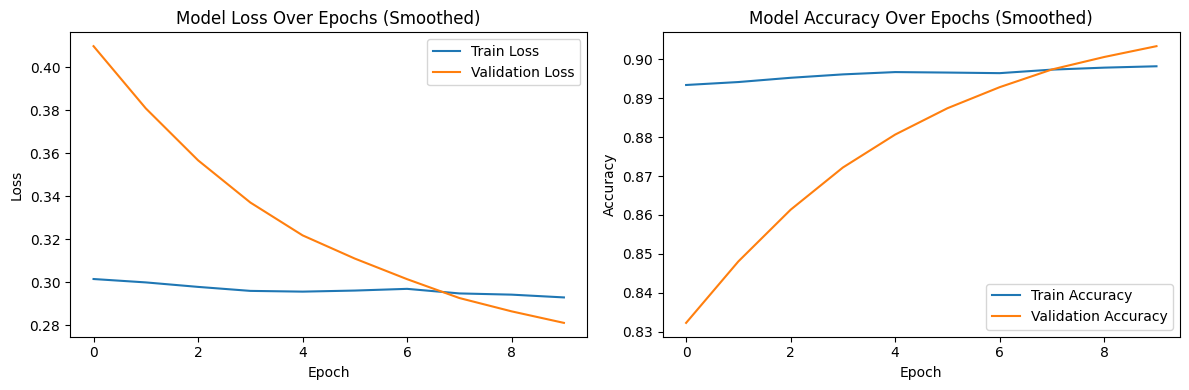

In [74]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define a learning rate schedule function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return  float(lr * tf.math.exp(-0.1).numpy())

# Implement learning rate scheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with early stopping and learning rate scheduler
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

# Smooth the curves
smooth_train_loss = smooth_curve(history.history['loss'])
smooth_val_loss = smooth_curve(history.history['val_loss'])
smooth_train_acc = smooth_curve(history.history['accuracy'])
smooth_val_acc = smooth_curve(history.history['val_accuracy'])

# Plot smoothed training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(smooth_train_loss, label='Train Loss')
plt.plot(smooth_val_loss, label='Validation Loss')
plt.title('Model Loss Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot smoothed training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(smooth_train_acc, label='Train Accuracy')
plt.plot(smooth_val_acc, label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


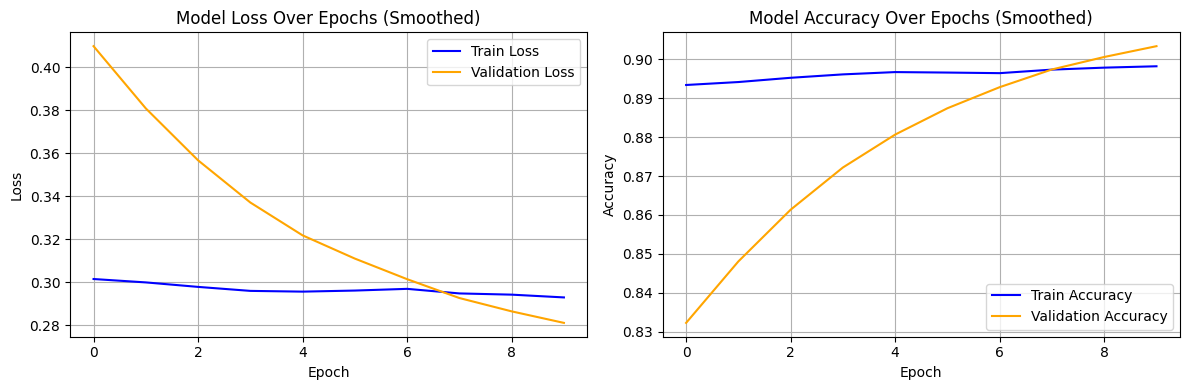

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Smoothing function
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Smooth the curves
smooth_train_loss = smooth_curve(history.history['loss'])
smooth_val_loss = smooth_curve(history.history['val_loss'])
smooth_train_acc = smooth_curve(history.history['accuracy'])
smooth_val_acc = smooth_curve(history.history['val_accuracy'])

# Enhanced Plot for Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(smooth_train_loss, label='Train Loss', color='blue')
plt.plot(smooth_val_loss, label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Enhanced Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(smooth_train_acc, label='Train Accuracy', color='blue')
plt.plot(smooth_val_acc, label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Epochs (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()




)




# Mean Shap Values

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# Assuming shap_values is the list of SHAP values you provided
shap_values = shap_values[0]  # Use the first element if shap_values is a list

# Calculate the mean absolute SHAP values
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)

In [77]:
# Create a DataFrame for better visualization
feature_names =X_test.columns.tolist()

mean_abs_shap_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean |SHAP Value|': mean_abs_shap_values
}).sort_values(by='Mean |SHAP Value|', ascending=False)

# Display the DataFrame
print(mean_abs_shap_df)


                     Feature  Mean |SHAP Value|
6                       EURL           0.150491
2                       EUFL           0.139101
4                       EUFR           0.106679
8                       EURR           0.077354
5                       IURL           0.066818
1                       IUFL           0.039571
7                       IURR           0.032642
3                       IUFR           0.027571
9                Temperature           0.007399
0  Months after giving birth           0.006832


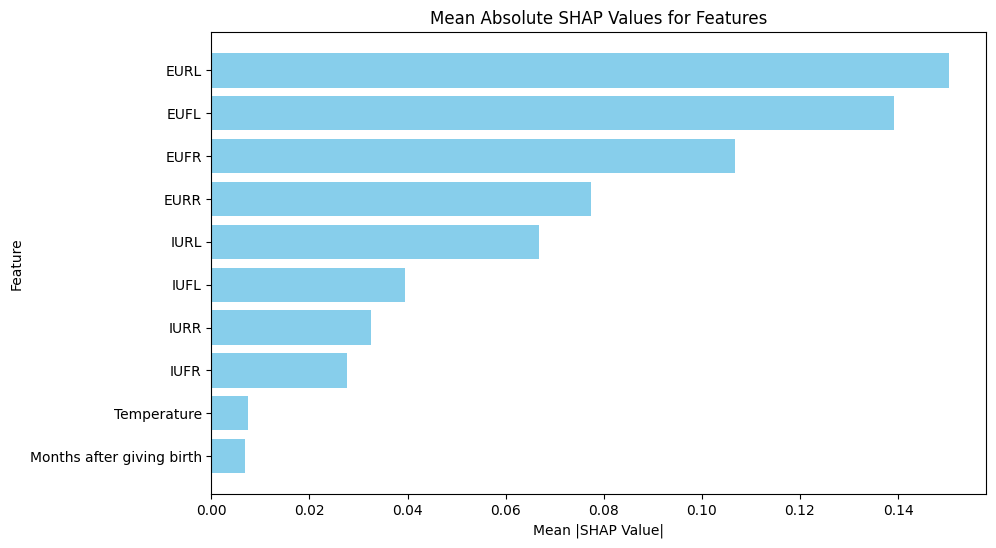

In [78]:
# Plot the mean absolute SHAP values
plt.figure(figsize=(10, 6))
plt.barh(mean_abs_shap_df['Feature'], mean_abs_shap_df['Mean |SHAP Value|'], color='skyblue')
plt.xlabel('Mean |SHAP Value|')
plt.ylabel('Feature')
plt.title('Mean Absolute SHAP Values for Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


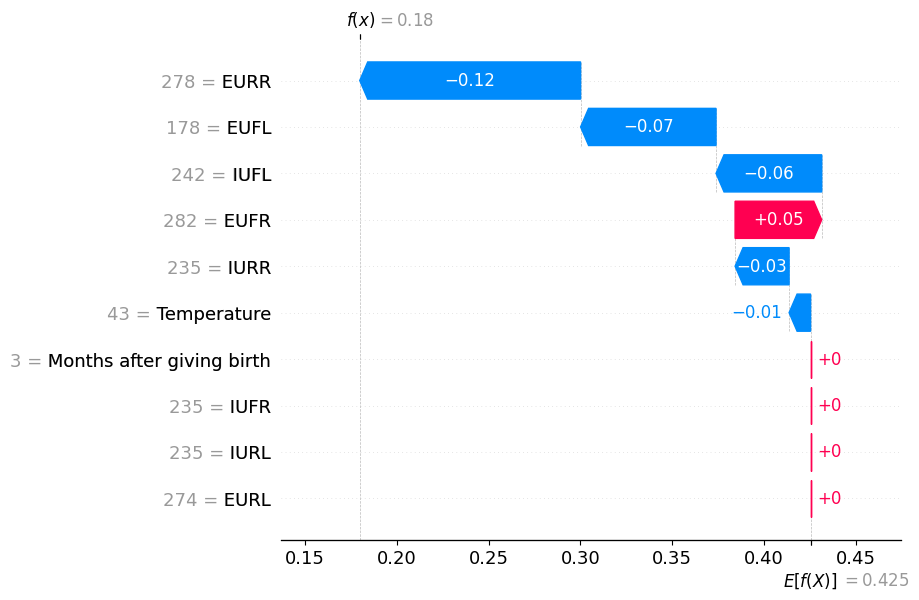

In [79]:
shap.plots.waterfall(shap_values_expl_1[0])

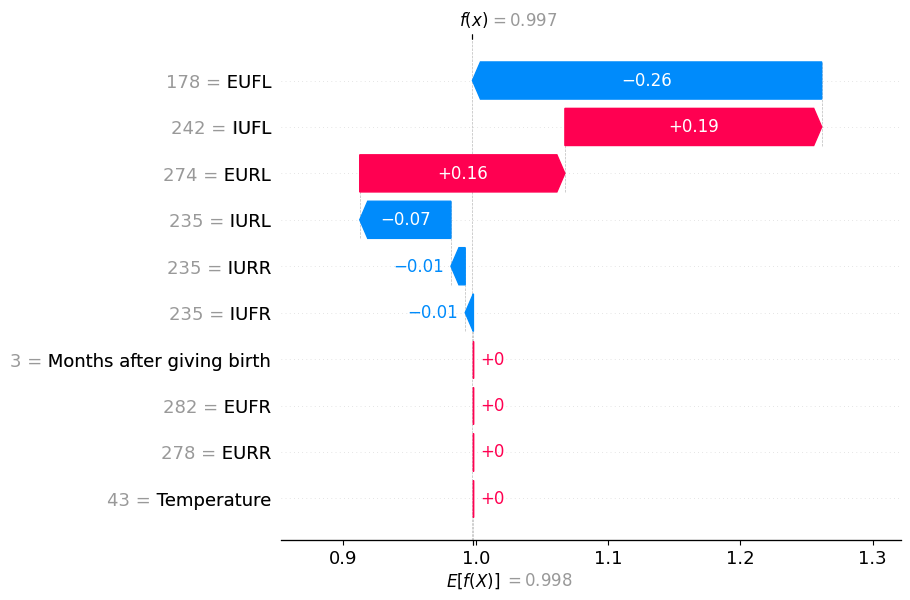

In [80]:
shap.plots.waterfall(shap_values_expl[0])

In [81]:
use_case_1 = pd.read_csv('/kaggle/input/test-cases/S2. Example Input.csv')
use_case_1

Months_after_giving_birth  IUFL  EUFL  IUFR  EUFR  IURL  EURL  IURR  EURR  \
0                          1   155   183   155   189   155   182   155   186   
1                          1   150   186   150   181   150   185   150   188   
2                          1   152   182   152   182   150   181   152   181   
3                          1   229   269   229   270   229   270   229   271   
4                          1   234   274   231   274   229   276   235   276   
5                          1   239   275   235   274   230   279   239   277   

   Temperature      ID  
0           40  Cow123  
1           41  Cow124  
2           40  Cow125  
3           40  Cow126  
4           40  Cow127  
5           40  Cow128

In [82]:
X_use_case_1 = use_case_1.drop(columns=[ 'ID'])
X_use_case_1

Months_after_giving_birth  IUFL  EUFL  IUFR  EUFR  IURL  EURL  IURR  EURR  \
0                          1   155   183   155   189   155   182   155   186   
1                          1   150   186   150   181   150   185   150   188   
2                          1   152   182   152   182   150   181   152   181   
3                          1   229   269   229   270   229   270   229   271   
4                          1   234   274   231   274   229   276   235   276   
5                          1   239   275   235   274   230   279   239   277   

   Temperature  
0           40  
1           41  
2           40  
3           40  
4           40  
5           40

In [83]:

n_features = X_use_case_1.shape[1]
X_use_case_1_reshape = X_use_case_1.values.reshape((X_use_case_1.shape[0], 1, n_features))

print(n_features)
X_use_case_1_reshape

10


array([[[  1, 155, 183, 155, 189, 155, 182, 155, 186,  40]],

       [[  1, 150, 186, 150, 181, 150, 185, 150, 188,  41]],

       [[  1, 152, 182, 152, 182, 150, 181, 152, 181,  40]],

       [[  1, 229, 269, 229, 270, 229, 270, 229, 271,  40]],

       [[  1, 234, 274, 231, 274, 229, 276, 235, 276,  40]],

       [[  1, 239, 275, 235, 274, 230, 279, 239, 277,  40]]])

In [84]:
predicted_result = model.predict(X_use_case_1_reshape)
predicted_result
binary_result = (predictions > 0.5).astype(int)
binary_result


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [85]:
Y_use_case_1 = binary_result

In [86]:
X_use_case_1_shap = X_use_case_1.values

X_use_case_1_shap 

array([[  1, 155, 183, 155, 189, 155, 182, 155, 186,  40],
       [  1, 150, 186, 150, 181, 150, 185, 150, 188,  41],
       [  1, 152, 182, 152, 182, 150, 181, 152, 181,  40],
       [  1, 229, 269, 229, 270, 229, 270, 229, 271,  40],
       [  1, 234, 274, 231, 274, 229, 276, 235, 276,  40],
       [  1, 239, 275, 235, 274, 230, 279, 239, 277,  40]])

In [87]:
explainer = shap.KernelExplainer(model_predict, shap.sample(X_use_case_1_shap, 100))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [88]:
shap_values_use_case_v1 = explainer.shap_values(X_use_case_1_shap, nsamples=100)

  0%|          | 0/6 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [89]:
shap_values_use_case_v1 

[array([[ 0.        ,  0.13086285, -0.13384316,  0.        , -0.06179772,
          0.08812732, -0.08255615,  0.02204598,  0.03716091,  0.        ],
        [ 0.        ,  0.14126576, -0.13544813,  0.        , -0.07135473,
          0.03520952, -0.05632748,  0.04524172,  0.04141358,  0.        ],
        [ 0.        ,  0.11477759, -0.1388537 ,  0.        , -0.05870063,
          0.04357806, -0.09546816,  0.0750362 ,  0.05963083,  0.        ],
        [ 0.        , -0.10423832,  0.12476947,  0.        ,  0.04694051,
         -0.04871846,  0.07598849, -0.07085073, -0.04115199,  0.01726093],
        [ 0.        , -0.11074859,  0.09863375,  0.04961001,  0.09180871,
         -0.07110598,  0.0830919 , -0.03702285, -0.09148514, -0.0127819 ],
        [ 0.        , -0.12196196,  0.14244348,  0.        ,  0.04080944,
         -0.05925977,  0.09456229, -0.03570126, -0.06089231,  0.        ]])]

In [90]:
shap.initjs()
single_record_features =X_use_case_1_shap[5]
# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value, shap_values_use_case_v1[0][5], single_record_features,     # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

In [91]:
shap.initjs()
single_record_features =X_use_case_1_shap[2]
# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value, shap_values_use_case_v1[0][2], single_record_features,     # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

In [92]:
shap.initjs()
single_record_features =X_use_case_1_shap[0]
# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value, shap_values_use_case_v1[0][0], single_record_features,     # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

In [93]:
shap.initjs()
single_record_features =X_use_case_1_shap[1]
# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value, shap_values_use_case_v1[0][1], single_record_features,     # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

In [94]:
shap.initjs()
single_record_features =X_use_case_1_shap[3]
# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value, shap_values_use_case_v1[0][3], single_record_features,     # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

In [95]:
shap.initjs()
single_record_features =X_use_case_1_shap[5]
# Generate the force plot for the first record correctly
shap.force_plot(
    explainer.expected_value, shap_values_use_case_v1[0][4], single_record_features,     # Feature values for the single record
    feature_names=X_test.columns.tolist()  # Names of the features
)

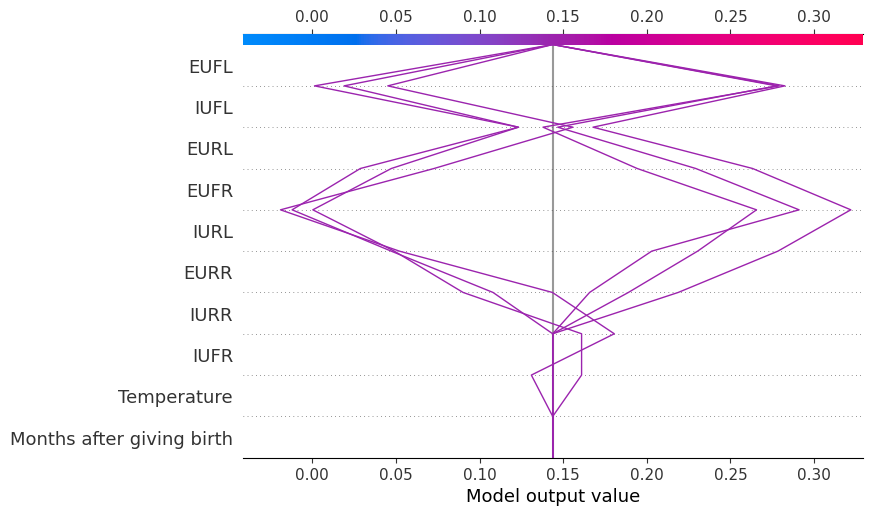

In [96]:
shap.decision_plot(explainer.expected_value, shap_values_use_case_v1[0], feature_names=X_test.columns.tolist(),)

In [97]:
shap_values_use_case_v1

[array([[ 0.        ,  0.13086285, -0.13384316,  0.        , -0.06179772,
          0.08812732, -0.08255615,  0.02204598,  0.03716091,  0.        ],
        [ 0.        ,  0.14126576, -0.13544813,  0.        , -0.07135473,
          0.03520952, -0.05632748,  0.04524172,  0.04141358,  0.        ],
        [ 0.        ,  0.11477759, -0.1388537 ,  0.        , -0.05870063,
          0.04357806, -0.09546816,  0.0750362 ,  0.05963083,  0.        ],
        [ 0.        , -0.10423832,  0.12476947,  0.        ,  0.04694051,
         -0.04871846,  0.07598849, -0.07085073, -0.04115199,  0.01726093],
        [ 0.        , -0.11074859,  0.09863375,  0.04961001,  0.09180871,
         -0.07110598,  0.0830919 , -0.03702285, -0.09148514, -0.0127819 ],
        [ 0.        , -0.12196196,  0.14244348,  0.        ,  0.04080944,
         -0.05925977,  0.09456229, -0.03570126, -0.06089231,  0.        ]])]

In [98]:
shap_values_use_case_v1_flat = np.array(shap_values_use_case_v1).reshape((6, 10))

In [99]:

use_case_values_expl = shap.Explanation(values=shap_values_use_case_v1_flat, base_values=explainer.expected_value, data=X_use_case_1_shap, feature_names=X_test.columns.tolist())

use_case_values_expl

.values =
array([[ 0.        ,  0.13086285, -0.13384316,  0.        , -0.06179772,
         0.08812732, -0.08255615,  0.02204598,  0.03716091,  0.        ],
       [ 0.        ,  0.14126576, -0.13544813,  0.        , -0.07135473,
         0.03520952, -0.05632748,  0.04524172,  0.04141358,  0.        ],
       [ 0.        ,  0.11477759, -0.1388537 ,  0.        , -0.05870063,
         0.04357806, -0.09546816,  0.0750362 ,  0.05963083,  0.        ],
       [ 0.        , -0.10423832,  0.12476947,  0.        ,  0.04694051,
        -0.04871846,  0.07598849, -0.07085073, -0.04115199,  0.01726093],
       [ 0.        , -0.11074859,  0.09863375,  0.04961001,  0.09180871,
        -0.07110598,  0.0830919 , -0.03702285, -0.09148514, -0.0127819 ],
       [ 0.        , -0.12196196,  0.14244348,  0.        ,  0.04080944,
        -0.05925977,  0.09456229, -0.03570126, -0.06089231,  0.        ]])

.base_values =
array([0.14375339])

.data =
array([[  1, 155, 183, 155, 189, 155, 182, 155, 186,  40],
   

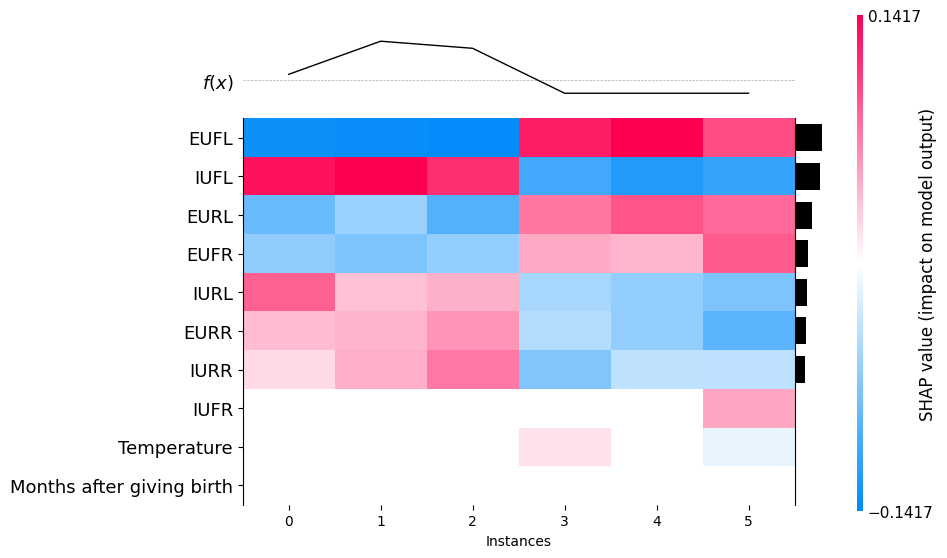

In [100]:
shap.plots.heatmap(use_case_values_expl, max_display=15)

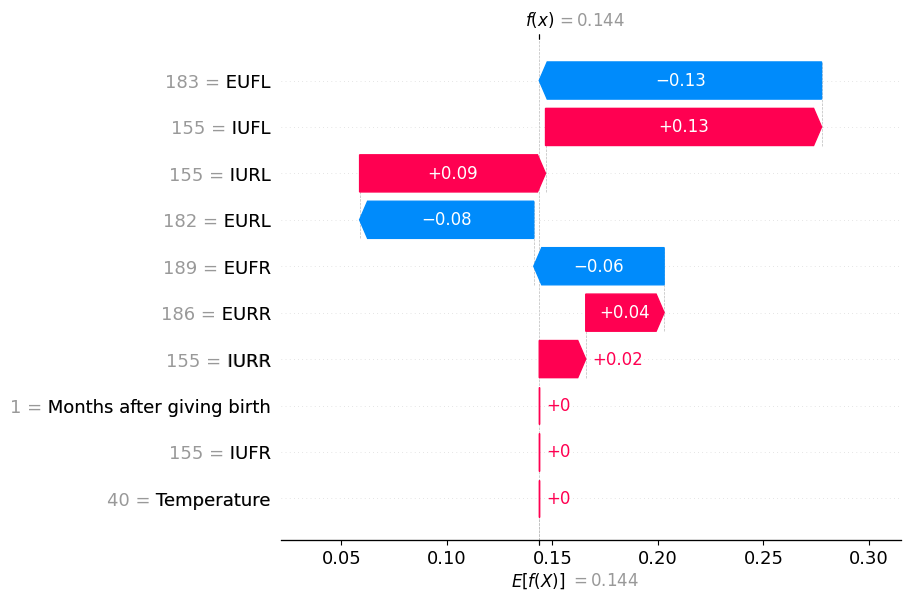

In [101]:
shap.plots.waterfall(use_case_values_expl[0])

In [102]:
# Print the number of explanations in use_case_values_expl
print(f"Number of explanations: {len(use_case_values_expl)}")

# Print the shape of the values in use_case_values_expl
print(f"Shape of values: {use_case_values_expl.values.shape}")

# Print the first few values to see the structure
print("Values:", use_case_values_expl.values[:5])
print("Base values:", use_case_values_expl.base_values)
print("Data:", use_case_values_expl.data[:5])


Number of explanations: 6
Shape of values: (6, 10)
Values: [[ 0.          0.13086285 -0.13384316  0.         -0.06179772  0.08812732
  -0.08255615  0.02204598  0.03716091  0.        ]
 [ 0.          0.14126576 -0.13544813  0.         -0.07135473  0.03520952
  -0.05632748  0.04524172  0.04141358  0.        ]
 [ 0.          0.11477759 -0.1388537   0.         -0.05870063  0.04357806
  -0.09546816  0.0750362   0.05963083  0.        ]
 [ 0.         -0.10423832  0.12476947  0.          0.04694051 -0.04871846
   0.07598849 -0.07085073 -0.04115199  0.01726093]
 [ 0.         -0.11074859  0.09863375  0.04961001  0.09180871 -0.07110598
   0.0830919  -0.03702285 -0.09148514 -0.0127819 ]]
Base values: [0.14375339]
Data: [[  1 155 183 155 189 155 182 155 186  40]
 [  1 150 186 150 181 150 185 150 188  41]
 [  1 152 182 152 182 150 181 152 181  40]
 [  1 229 269 229 270 229 270 229 271  40]
 [  1 234 274 231 274 229 276 235 276  40]]
